## Import packages and the dataset

Before downloading beginnig with this script, you should make sure that you have downloaded:
weather_mapping.py
load_data_filtered.py
and download the filtered dataset through the notebook Preprocces-data.ipynb to get the csv file 
Car Congestion without windspeed.csv
everything can be found on the Fugled30 github

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import calplot
import folium

from folium.plugins import HeatMapWithTime
from collections import defaultdict
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess


In [3]:
# Import own functions and files
from load_data_filtered import load_data
from weather_mapping import weather_map

In [4]:
path = 'Car Congestion without windspeed.csv'
data = load_data(path,weather_map)

In [5]:
df_NYC = data[data["City"] == "New York"]
df_LA = data[data["City"] == "Los Angeles"]

---------------

# **Motivation**.
#### **What is your dataset?**
Our dataset is a comprehensive, nationwide collection of traffic congestion events recorded across **49 U.S. states** between **March 2016 and September 2022** [1]. It contains approximately **33 million records** of congestion incidents (12 GB), which were gathered using multiple APIs that stream real-time traffic data. These APIs compile information from various sources, including: 

- Federal and state departments of transportation  
- Law enforcement agencies  
- Traffic cameras  
- Road sensors

The dataset captures a wide range of both numeric and categorical attributes related to each congestion event along with both spatial and temporal features such as:

- **Severity**  
- **Delay from typical traffic**  
- **Associated weather conditions**
- **Timestamp** (YYYY-MM-DD: HH-MM-SS)
- **Coordinates**, **Street Names** etc. 

This makes it suitable for **in-depth analysis** of traffic patterns across time, location, and various contributing factors.

> **Note:** While the dataset is large and diverse, some days may have missing data due to occasional network issues during collection. Additionally, the dataset is **no longer being updated**..


#### **What was your goal for the end user's experience?**
We chose this dataset to explore traffic congestion in the U.S. because it is a real-world issue that affects millions of people every day—whether it is longer commutes, more fuel usage, or lost time and productivity. As it impacts so many people on both personal and possibly professional levels, we believe it is a topic that is both relatable and worth diving into.

Due to the dataset’s large size, we decided to narrow our focus to New York City and Los Angeles. These two cities are famously known for many reasons but they are also among the most traffic heavy cities along with being the top 2 most densely populated cities in the US [2]. Further, LA and NYC also represent different parts of the country with their geographic placement on opposite coasts, paired with differences in climate, infrastructure and public transit availability and population density. This contrast leaves us great opportunity to explore and compare how different **(environmental and structural)** factors may influence traffic congestion patterns and intensity.


Our main goal is to help users spot **where and when traffic tends to be the worst** in each city, and to see how things like **weather, time of day, or even the day of the week** play a role. With this, we hope to discover patterns that could help improve **traffic management**, or even just help **commuters make better travel choices**. As they say, time is money — and we hope to uncover ways to save both time and money.

In the end, we hope our work not only offers **useful data insights** but also adds to the conversation about making city travel **smarter, more efficient, and more sustainable** for everyone.

------------------

# **Basic stats. Let's understand the dataset better**
#### **Write about your choices in data cleaning and preprocessing**
As mentioned earlier, we narrowed our analysis to **New York City and Los Angeles**, selected due to their high traffic volumes, contrasting infrastructures, and differing climates. After filtering the full dataset, we were left with **1.584.650 observations across 30 attributes**, reducing the size from 12 GB to 0.48 GB.

We began preprocessing by addressing missing data. Upon inspection, several weather-related attributes had significant gaps. To retain data quality without overly compromising on sample size, we applied a threshold:

- We dropped any attribute with more than 100,000 missing values, which led to the removal of:
    - `'WindChill(F)'`  
    - `'WindSpeed(mph)'`  
    - `'Precipitation(in)'`  
    - `'Weather_Event'`

While we were initially reluctant to drop Precipitation, doing so avoided losing over a third of the dataset due to missing values. 
The remaining attributes had fewer than 100,000 missing values each - roughly **7% of the dataset** at max - which we considered acceptable and chose to retain those attributes. After dropping rows with missing values (74.758), the final dataset consisted of **1.509.892** observations and **26 attributes** preserving approximately 95% of the filtered data.

We also addressed the **timestamp attributes**, specifically `'StartTime'` and `'EndTime'`. These were originally formatted as ISO 8601 strings:  
`"%Y-%m-%dT%H:%M:%S.%f%z"`  
where `%z` indicates the timezone offset (e.g., `-05:00` means 5 hours behind UTC).

Since our analysis focuses on **local congestion patterns**, we chose to **ignore the timezone offsets** and instead converted these timestamps into simpler datetime objects using the format:  
`"%Y-%m-%d %H:%M:%S"`  
This allowed us to work directly with local time to better understand when and where congestion events occur.

From the **note**, we are also inclined to investigate, which days that have missing observations in the whole dataset.

The dataset spans from March 2016 to September 2022. Although the start and end years are incomplete, we chose to include them in our analysis since the missing data falls primarily between October and March that, as later analysis shows, experience the highest congestion levels and are therefore too important to exclude. 
That said, we should interpret results from 2016 and 2022 with caution, as they contain the highest number of missing days (16 and 15 respectively), which may affect some conclusions drawn in later analyses **(Code below)**

In [10]:
# Generate full date range
full_date_range = pd.date_range(start='2016-03-22', end='2022-09-08', freq='D').date
existing_dates = data['StartTime'].dt.date.unique()

# Identify missing dates
missing_dates = sorted(set(full_date_range) - set(existing_dates))

# Count missing dates per year and month
missing_count = defaultdict(lambda: defaultdict(int))

for date in missing_dates:
    year = date.year
    month = date.strftime('%B') 
    missing_count[year][month] += 1

# Print result
for year in sorted(missing_count.keys()):
    print(f"\nYear {year}:")
    for month in sorted(missing_count[year], key=lambda m: pd.to_datetime(m, format='%B').month):
        count = missing_count[year][month]
        print(f"  {month}: {count} missing days")


Year 2016:
  March: 2 missing days
  April: 9 missing days
  May: 4 missing days
  October: 1 missing days

Year 2017:
  May: 6 missing days
  July: 1 missing days

Year 2019:
  August: 1 missing days

Year 2020:
  March: 3 missing days
  April: 1 missing days
  May: 1 missing days
  December: 1 missing days

Year 2021:
  July: 2 missing days
  August: 1 missing days
  October: 4 missing days

Year 2022:
  January: 2 missing days
  March: 6 missing days
  May: 5 missing days
  June: 2 missing days


#### **Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.**


For a reasonable comparison between NYC and LA, we must first know how many observations the dataset has in each city. For NYC, we have $604.606$ observations and for LA we have $905.284$ observations. Further, the size of the cities also matter. NYC is $778.2$ $\text{km}^2$ [5] whereas LA is $1.302$ $\text{km}^2$ [6]. This suggests that we should also consider the number of streets in each city where car congestions have occurred. For NYC, the number of streets reported where car congestions have occured is ``606``, whereas in LA, the reported number of streets is ``1721`` - more than double **(Code below)**. This indicates, that although NYC has 30% less observations than LA, the congestions that do occur in NYC are likely to happen on fewer, more heavily trafficked streets whereas for LA, it has more streets and highways to distribute over. 

In [20]:
### Code for the basic stats ### 

# Number of observations in each city
print(f'The number of observations in NYC: {len(df_NYC)}')
print(f'The number of observations in LA: {len(df_LA)}\n')


# Number of streets in each city
print(f"The number of streets in NYC where car congestions have occured is: {len(df_NYC['Street'].unique())}")
print(f"The number of streets in LA where car congestions have occured is: {len(df_LA['Street'].unique())}")

The number of observations in NYC: 604607
The number of observations in LA: 905285

The number of streets in NYC where car congestions have occured is: 607
The number of streets in LA where car congestions have occured is: 1721


Further we took a look at the attributes ``Severity``, ``Distance(mi)`` and ``DelayFromTypicalTraffic(mins)``. Due to only 2 total observations with ``Severity`` level 4, we chose to exclude these observations from the analysis **(Code below)**. Further, to understand the relationship between ``Severity`` and ``Distance(mi)`` and  ``DelayFromTypicalTraffic(mins)``, we decided to calculate the mean for each of these 2 attributes in regards to each severity level between the LA and NYC. As expected, higher severity levels were generally associated with longer distances and greater delays. 


The interesting observation, was that for the same severity levels, the distance was longer for LA compared to NYC, however the delay was less in LA compared to NYC. This suggests once again, that what makes a congestion severe in NYC, is not comparable to what makes a congestion severe in LA, where the congestions are longer but move faster. 

In [23]:
## Code for checking the count of each severity level for each city
severity_pivot = data.groupby(['City', 'Severity']).size().reset_index(name='Count')
severity_pivot = severity_pivot.pivot(index='Severity', columns='City', values='Count')
severity_pivot

City,Los Angeles,New York
Severity,,
0,352333,316866
1,364365,211992
2,152702,72369
3,35884,3379
4,1,1


In [26]:
# Removal of severity level 2 due to only 2 observations
df_NYC = df_NYC[df_NYC["Severity"] != 4]
df_LA = df_LA[df_LA["Severity"] != 4]

In [29]:
# Relationship between Severity and Distance(mi) and DelayFromTypicalTraffic(mins)
grouped_stats_NYC = df_NYC.groupby('Severity')[['Distance(mi)', 'DelayFromTypicalTraffic(mins)']].mean()
print("NYC: Severity in relation to Distance(mi) and Delay from typical traffic (mins)")
print(grouped_stats_NYC)

grouped_stats_LA = df_LA.groupby('Severity')[['Distance(mi)', 'DelayFromTypicalTraffic(mins)']].mean()
print("\nLA: Severity in relation to Distance(mi) and Delay from typical traffic (mins)")
print(grouped_stats_LA)

NYC: Severity in relation to Distance(mi) and Delay from typical traffic (mins)
          Distance(mi)  DelayFromTypicalTraffic(mins)
Severity                                             
0             1.309319                       0.681948
1             2.171484                       1.953750
2             3.308091                       3.974277
3             4.656487                      11.203190

LA: Severity in relation to Distance(mi) and Delay from typical traffic (mins)
          Distance(mi)  DelayFromTypicalTraffic(mins)
Severity                                             
0             1.379215                       0.671641
1             2.445327                       1.481244
2             4.419377                       2.804567
3             9.854754                       6.457423


# Data Analysis
#### Describe your data analysis and explain what you've learned about the dataset.

# Temporal distributions

## Yearly and weekly trends - Histograms

We began by creating histograms and calender plots to explore the distribution of congestion events over time — specifically across different **hours of the day**, **days of the week**, and **months of the year**. We generated these plots separately for **New York City** and **Los Angeles** to allow for a direct comparison between the two.

findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

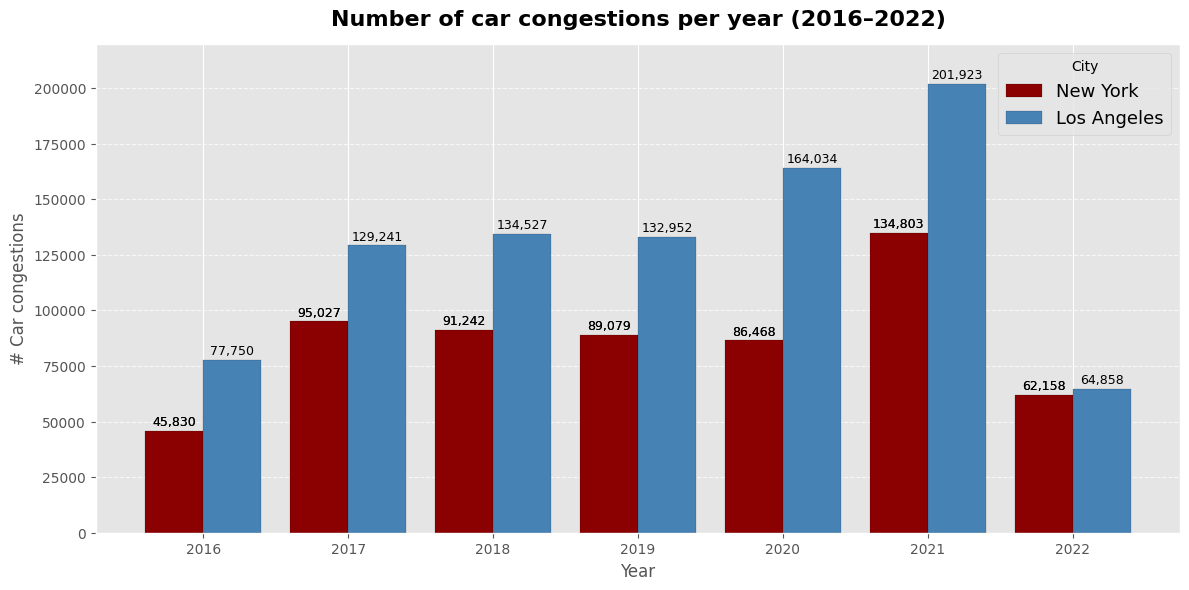

In [32]:
cities = ["New York", "Los Angeles"]
colors = ['darkred', 'steelblue']
year_range = list(range(2016, 2023))  
bar_width = 0.4

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'

fig, ax = plt.subplots(figsize=(12, 6))

# X positions for groups
x = np.arange(len(year_range))

# Prepare bars for each city
for i, city in enumerate(cities):
    city_data = data[data['City'] == city]
    year_counts = city_data.groupby(city_data['StartTime'].dt.year).size()
    year_counts = year_counts.reindex(year_range, fill_value=0).values

    # Offset bar positions for grouped bars
    positions = x + (i - 0.5) * bar_width

    bars = ax.bar(positions, year_counts, width=bar_width, label=city, color=colors[i], edgecolor='black', linewidth=0.1)

    # Add annotations
    # for j, val in enumerate(year_counts):
    #     ax.text(positions[j], val + 5000, f"{val:,}", ha='center', va='bottom', fontsize=9, color='dimgrey')

    # Add value labels
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 1000,  # Adjust as needed
                    f'{int(height):,}',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    color='black'
                )

# Format plot
ax.set_xticks(x)
ax.set_xticklabels([str(y) for y in year_range])
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('# Car congestions', fontsize=12)
ax.set_title('Number of car congestions per year (2016–2022)', fontsize=16, fontweight='bold', y = 1.02)
ax.legend(title='City', fontsize = 13)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
#ax.set_ylim(0, data.groupby(data['StartTime'].dt.year).size().max())
ax.set_ylim(0,220000)
plt.tight_layout()
plt.show()

/tmp/ipykernel_43/3797453180.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = filtered.groupby(['Weekday', 'City']).size().unstack(fill_value=0).reindex(ordered_days)
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not foun

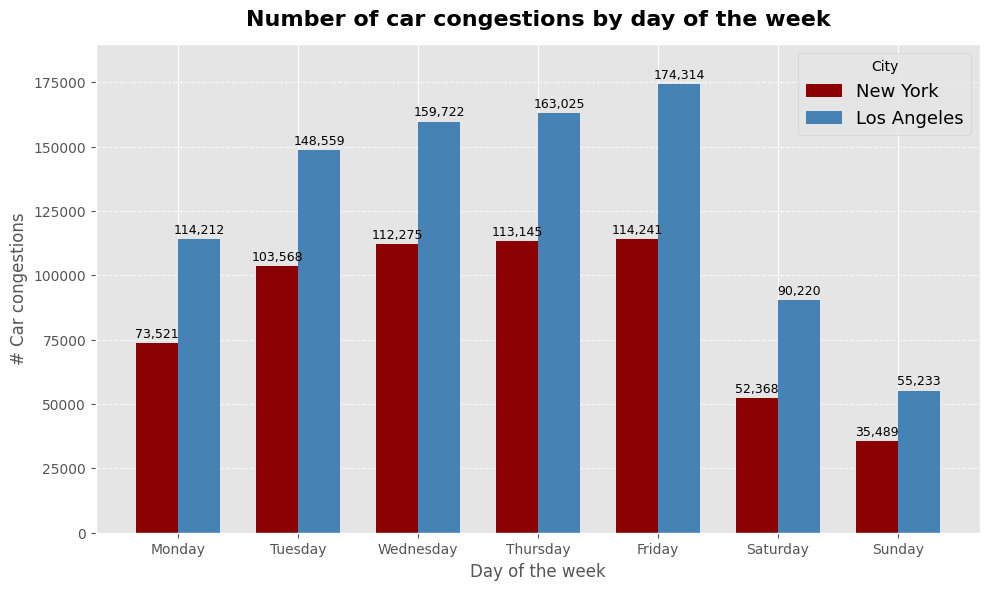

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'

# Convert to datetime if needed
data['StartTime'] = pd.to_datetime(data['StartTime'])

# Extract weekday name
data['Weekday'] = data['StartTime'].dt.day_name()

# Order of weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['Weekday'] = pd.Categorical(data['Weekday'], categories=ordered_days, ordered=True)

# Filter to NYC and LA
cities = ['New York', 'Los Angeles']
filtered = data[data['City'].isin(cities)]

# Group data by weekday and city
grouped = filtered.groupby(['Weekday', 'City']).size().unstack(fill_value=0).reindex(ordered_days)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(ordered_days))
width = 0.35  # width of the bars

colors = ['darkred', 'steelblue']
ax.bar(x - width/2, grouped['New York'], width=width, label='New York', color=colors[0], linewidth = 0.1)
ax.bar(x + width/2, grouped['Los Angeles'], width=width, label='Los Angeles', color=colors[1], linewidth = 0.1)

# Add labels on top
for i in range(len(ordered_days)):
    ny_val = grouped['New York'].iloc[i]
    la_val = grouped['Los Angeles'].iloc[i]
    if ny_val > 0:
        ax.text(x[i] - width/2, ny_val + 1000, f'{ny_val:,}', ha='center', va='bottom', fontsize=9, color='black')
    if la_val > 0:
        ax.text(x[i] + width/2, la_val + 1000, f'{la_val:,}', ha='center', va='bottom', fontsize=9, color='black')

# Style
ax.set_xticks(x)
ax.set_ylim(0,190000)
ax.set_xticklabels(ordered_days, rotation=0)
ax.set_title("Number of car congestions by day of the week", fontweight="bold", fontsize=16, y = 1.02)
ax.set_xlabel("Day of the week", fontsize=12)
ax.set_ylabel("# Car congestions", fontsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.legend(title = 'City', fontsize = 13)


plt.tight_layout()
plt.show()

## Yearly/weekly trends - Calendar plot

In [38]:
import pandas as pd
import calplot
import matplotlib.pyplot as plt
import logging
import mpld3

# Disable font manager logging warnings
logging.getLogger('matplotlib.font_manager').disabled = True

# Style and font
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'
plt.rcParams['font.size'] = 16  # Default font size

# Parse datetime
data['StartTime'] = pd.to_datetime(data['StartTime'])
data['day of year'] = data['StartTime'].dt.dayofyear

# Cities to process
cities = ["New York", "Los Angeles"]

for city in cities:
    city_data = data[data['City'] == city]

    # Average by day of year
    avg_daily_congestion = city_data.groupby('day of year').size().groupby(level=0).mean()
    date_range = pd.date_range(start='2023-01-01', periods=365, freq='D')
    avg_daily_congestion = avg_daily_congestion.reindex(range(1, 366), fill_value=0)
    avg_daily_congestion.index = date_range

    # Plot calendar heatmap
    fig, ax = calplot.calplot(
        avg_daily_congestion,
        cmap='YlGn',
        colorbar=True,
        yearlabels=False,
        suptitle='',  # Suppress default title
        figsize=(16, 2.5)
    )

    # Manually add styled title
    fig.suptitle(f"Average daily car congestions across 2016-2022 — {city}",
                 fontsize=16, fontweight='bold', y=1.03)

    # Save/export
    mpld3.save_html(fig, f"calendar_avg_congestion_{city.replace(' ', '_')}.html")
    plt.savefig(f"calendar_avg_congestion_{city.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()


ModuleNotFoundError: No module named 'mpld3'

### Results of weekly, yearly trends

As there are 3 months missing, we see indeed that 2016 and 2022 are the years with the least observations for both cities. On the other hand, we see that the number of car congestions in 2017-2019 are fairly stable in both cities. However LA peaks a bit more than previous years in 2020, and in 2021 we see both cities having a significant increase in number of car congestions. Further, online research shows that New York City, indeed had a *Great Gotham Vroom Boom in 2020*, leading to 19% more bought cars from June to July compared to 2019 due to the first wave of Covid. Due to this, there was an increase in car sales, as people tried to avoid taking public transportation [3][4]. New York City being very public-transport dependent and very urban dense, it would be plausible that the number of car congestions increased during this time. The same spike can be seen for Los Angeles, that is heavily car-centric, that people were likely reluctant to take public transport. Further, LA hosts much of TV production that was otherwise shut down during Covid, and boom in delivery services along with infrastructure projects [4]. 


Finally, it was clear that **Los Angeles experienced a higher overall number of congestion events than New York City**. This difference could be attributed to several factors, such as the cities' different urban layouts, public transportation systems, and population sizes. 

The different visualizations revealed that both cities showed similar patterns in terms of when congestion occurs. **Weekdays were consistently more congested than weekends**. Friday stands out as the busiest day for both cities, with LA reaching over 170,000 congestion events. The numbers start to drop on Saturday and hit their lowest on Sunday, especially in NYC, with only around 35,000 events. This trend makes sense as people are commuting to work during the week, while weekends are typically more relaxed with fewer people on the road. 

Looking at the calender plot, we see that **winter months experienced more traffic events compared to summer months**. Further, we see that the least busy days are the 1. of January and 4. of July. This pattern may be explained by reduced activity due to post–New Year’s hangovers and, on the 4th, by many individuals being unable to drive due to alcohol consumption.

For both calendar plots, we have very similar tendencies. There is more busy months being in February, March, October, November, and the start of December, with the Christmas vacation reducing the congestion occurrences. A takeaway from this is that it looks like people are more happy to leave the car at home when the weather is warmer.


# The 24-hour cycle of NY and LA traffic

We are now looking at how the traffic congestions evolve through the 24-hour cycle of the day through Polar charts, Bokeh histogram plot and lastly a Geospatial  map.

## Severity levels by hours of the day - Polar charts

We also used **polar charts** to analyze the hours of day when different **severity levels** of congestion are most common in each city.

findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

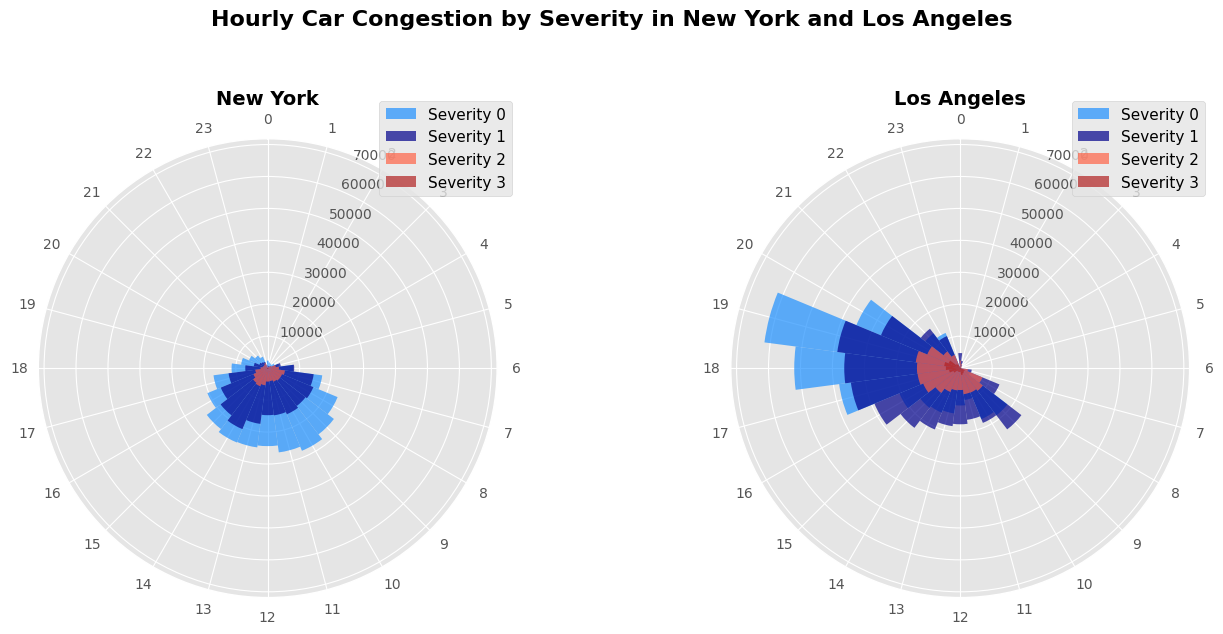

In [43]:
df_NYC = data[data["City"] == "New York"]
df_LA = data[data["City"] == "Los Angeles"]

cities = ["New York", "Los Angeles"]
# Create a 1×2 subplot layout with polar projection
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))
axes = axes.flatten()

colors =  ['#1E90FF', '#00008B','#FF6347','#B22222']

# If severities are 1–4:
severity_colors = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]}

max_count = (df_LA.groupby(["Severity", df_LA["StartTime"].dt.hour]).size().unstack(fill_value=0)).values.max() + 10000 # Max count to set limit for the polar chart

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'

n = 24 # Change this depending on hour, day, month, year
# Loop over each city
for i, city in enumerate(cities):
    # Filter by city and remove Severity 4
    df_city = data[(data["City"] == city) & (data["Severity"] != 4)]

    # Group by hour and severity
    grouped = df_city.groupby([df_city["StartTime"].dt.hour, 'Severity']).size().unstack(fill_value=0)

    # Ensure all 24 hours are represented
    hours = np.arange(1,n+1)
    grouped = grouped.reindex(hours, fill_value=0)

    # Polar coordinates
    theta = np.linspace(0.0, 2 * np.pi, n, endpoint=False)
    width = 2 * np.pi / n

    # Plot each severity level as a stacked bar
    bottom = np.zeros(n)
    for severity in sorted(grouped.columns[:]):
        heights = grouped[severity].values
        color = severity_colors.get(severity)
        axes[i].bar(theta, heights, width=width, bottom=bottom, alpha=0.7, label=f'Severity {severity}', color=color)

    # Format the subplot
    axes[i].set_title(city, fontsize=14, fontweight='bold')
    axes[i].set_xticks(theta)
    axes[i].set_xticklabels(range(n))
    axes[i].set_theta_zero_location('N')
    axes[i].set_theta_direction(-1)
    axes[i].legend(loc='upper right', fontsize=11, bbox_to_anchor=(1.05, 1.1))
    axes[i].set_rlim(0, max_count)

# Layout
plt.suptitle("Hourly Car Congestion by Severity in New York and Los Angeles", fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## Results of severity levels by hours of the day

In **New York City**, congestion events were mainly concentrated during the **daytime hours from 7 AM to 5 PM**. During these hours, the severity levels were fairly evenly distributed, with **level 0 being the most common**, followed by **levels 1, 2, and 3** in increasing order of frequency.

In contrast, **Los Angeles** showed a different pattern. The busiest hours occurred between **4 PM and 8 PM**, during which **severity level 0** dominated. Interestingly, from **8 AM to 4 PM**, **severity level 1** was the most frequent, with level 0 coming in second. However, it's worth noting that between **8 AM and 4 PM**, the number of congestion events in **Los Angeles** is approximately the same as in **New York**. The key difference — and what contributes to LA having more overall congestion — may come from the **additional traffic between 4 PM and 8 PM**, where LA experiences significantly more congestion than NY.

These differences highlight how the timing and intensity of traffic congestion vary between the two cities, possibly due to differences in work schedules (**Los Angeles is known for having a later peak commute, partly due to its flexible work hours and industries like entertainment and tech** [7]), commuting behavior, or urban infrastructure.


## Severity levels by hours of the day - Bokeh plot

Further we changed the polar charts with **interactive Bokeh plots**, allowing users to select a specific **severity level** and view its distribution across the hours of the day for each city. This makes it easier to identify which severity levels are most dominant at different times.

In [ ]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column
from bokeh.themes import Theme
from bokeh.io import curdoc

output_notebook()

# Apply Bokeh theme to mimic ggplot style and set bold Tahoma fonts
curdoc().theme = Theme(json={
    "attrs": {
        "Figure": {
            "background_fill_color": "#EFEFEF",
            "border_fill_color": "#FFFFFF",
            "outline_line_color": "#444444"
        },
        "Axis": {
            "major_label_text_font": "Tahoma",
            "axis_label_text_font": "Tahoma",
            "major_label_text_font_size": "12pt",
            "axis_label_text_font_size": "14pt",
            "axis_label_text_font_style": "bold",
            "major_label_text_font_style": "bold"
        },
        "Title": {
            "text_font": "Tahoma",
            "text_font_size": "16pt",
            "text_font_style": "bold",
            "align": "center"
        },
        "Legend": {
            "label_text_font": "Tahoma",
            "label_text_font_size": "12pt",
            "label_text_font_style": "bold"
        }
    }
})

# Prepare data
data['StartTime'] = pd.to_datetime(data['StartTime'])
data['hour'] = data['StartTime'].dt.hour
data['Severity'] = data['Severity'].astype(str)

# City setup
cities = ['New York', 'Los Angeles']
initial_city = cities[0]

# Group and normalize data
def prepare_pivot(df):
    grouped = df.groupby(['hour', 'Severity']).size().reset_index(name='count')
    pivot = grouped.pivot(index='hour', columns='Severity', values='count').fillna(0)
    pivot = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)
    pivot = pivot.reindex(range(24), fill_value=0)
    pivot.reset_index(inplace=True)
    return pivot

# Build source dictionaries
city_sources = {}
severity_levels = sorted(data['Severity'].unique())[:4]

for city in cities:
    city_df = data[data['City'] == city]
    pivot = prepare_pivot(city_df)
    for sev in severity_levels:
        if sev not in pivot:
            pivot[sev] = 0.0
    city_sources[city] = pivot[["hour"] + severity_levels].to_dict(orient='list')

source = ColumnDataSource(data=city_sources[initial_city])

# Custom red/blue palette
colors = ['#1E90FF', '#00008B','#FF6347','#B22222']

# Create figure
p = figure(x_range=[str(h) for h in range(24)],
           height=400,
           width=800,
           title="Hourly Proportional Distribution of Accident Severities",
           x_axis_label='Hour of Day',
           y_axis_label='Proportion',
           toolbar_location=None,
           tools="")

# Plot each severity level
for i, severity in enumerate(severity_levels):
    p.vbar(x='hour', top=severity, width=0.9,
           source=source, color=colors[i],
           legend_label=f'Severity {severity}',
           muted_color=colors[i], muted_alpha=0.1)

p.legend.click_policy = 'hide'
from bokeh.layouts import row

# Move legend to right of plot
p.add_layout(p.legend[0], 'right')
p.legend[0].location = "center"
p.xaxis.major_label_orientation = 1

# Dropdown menu
city_select = Select(title="Select City", value=initial_city, options=cities)
city_select.js_on_change("value", CustomJS(args=dict(source=source, data_dict=city_sources),
    code="""
    const selected = cb_obj.value;
    const new_data = data_dict[selected];
    source.data = new_data;
    source.change.emit();
"""))

# Show final plot
show(column(city_select, p))


### Results of severity levels by hours of the day - bokeh plot
It's important to note that these plots represent **relative proportions** of severity levels rather than absolute event counts. Consequently, they don't capture the **total number of congestion events** occurring throughout the day, as the emphasis is on comparing severity levels rather than identifying peak congestion times. The visualizations show that in NYC, severity level 0 is the most prevalent overall, whereas in LA, the dominant severity level varies depending on the hour. Notably, severity level 2 tends to dominate during the early morning hours between 3 AM and 7 AM, which may indicate a recurring traffic pattern or a specific type of overnight activity. Whereas severity level 0 dominates in the day hous.

-----------------------------------------

## 24 hour cycle as a heatmap

Now we visualize some of these findings on a geospatial map to capture the overall flow of the congestion. 

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMapWithTime
from datetime import datetime, timedelta, time

# Set the grouping interval in minutes
interval_minutes = 5  # You can change this to 5, 30, etc.

# Define the date range (inclusive)
start_date = pd.to_datetime("2016-03-22")
end_date = pd.to_datetime("2022-09-08")

# Load dataset
df = pd.read_csv('Car Congestion without windspeed.csv', parse_dates=['StartTime'])

# Drop rows with missing key data
df = df.dropna(subset=['Start_Lat', 'Start_Lng', 'StartTime'])

# Filter to events from the selected date range only
df = df[(df['StartTime'] >= start_date) & (df['StartTime'] <= end_date)]

# Filter to Los Angeles bounding box
la_bbox = (33.7037, 34.3373, -118.6682, -118.1553)
la_data = df[
    (df['Start_Lat'] >= la_bbox[0]) & (df['Start_Lat'] <= la_bbox[1]) &
    (df['Start_Lng'] >= la_bbox[2]) & (df['Start_Lng'] <= la_bbox[3])
].copy()

# Round to time of day at given interval
interval_str = f'{interval_minutes}min'
la_data['time_of_day'] = la_data['StartTime'].dt.floor(interval_str).dt.time

# Sort and group
la_data = la_data.sort_values('time_of_day')
grouped = la_data.groupby('time_of_day')[['Start_Lat', 'Start_Lng']].apply(
    lambda x: x.values.tolist()
)

# Ensure full 24-hour coverage
times = [(datetime.combine(datetime.today(), time.min) + timedelta(minutes=i)).time()
         for i in range(0, 1440, interval_minutes)]
grouped = grouped.reindex(times, fill_value=[])
time_index = [t.strftime('%H:%M') for t in grouped.index]
heat_data = grouped.tolist()

# Create the map
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

# Add animated heat map
HeatMapWithTime(
    heat_data,
    index=time_index,
    radius=8,
    auto_play=True,
    max_opacity=0.6
).add_to(la_map)

# Display map inline
la_map
#la_map.save('la_time_map.html')

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMapWithTime
from datetime import datetime, timedelta, time

# Set the grouping interval in minutes
interval_minutes = 5  # You can change this to 5, 30, etc.

# Define the date range (inclusive)
start_date = pd.to_datetime("2016-03-22")
end_date = pd.to_datetime("2022-09-08")

# Load dataset
df = pd.read_csv('Car Congestion without windspeed.csv', parse_dates=['StartTime'])

# Drop rows with missing key data
df = df.dropna(subset=['Start_Lat', 'Start_Lng', 'StartTime'])

# Filter to events from the selected date range only
df = df[(df['StartTime'] >= start_date) & (df['StartTime'] <= end_date)]

# Filter to New York City bounding box
nyc_bbox = (40.4774, 40.9176, -74.2591, -73.7004)
ny_data = df[
    (df['Start_Lat'] >= nyc_bbox[0]) & (df['Start_Lat'] <= nyc_bbox[1]) &
    (df['Start_Lng'] >= nyc_bbox[2]) & (df['Start_Lng'] <= nyc_bbox[3])
].copy()

# Round to time of day at given interval
interval_str = f'{interval_minutes}min'
ny_data['time_of_day'] = ny_data['StartTime'].dt.floor(interval_str).dt.time

# Sort and group
ny_data = ny_data.sort_values('time_of_day')
grouped = ny_data.groupby('time_of_day')[['Start_Lat', 'Start_Lng']].apply(
    lambda x: x.values.tolist()
)

# Ensure full 24-hour coverage
times = [(datetime.combine(datetime.today(), time.min) + timedelta(minutes=i)).time()
         for i in range(0, 1440, interval_minutes)]
grouped = grouped.reindex(times, fill_value=[])
time_index = [t.strftime('%H:%M') for t in grouped.index]
heat_data = grouped.tolist()

# Create the map centered on NYC
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add animated heat map
HeatMapWithTime(
    heat_data,
    index=time_index,
    radius=8,
    auto_play=True,
    max_opacity=0.6
).add_to(ny_map)

# Display map inline
ny_map
#ny_map.save('ny_time_map.html')

# Feature Analysis

## Weather attributes - Boxplots


We also analyzed the distributions of various weather-related attributes — **`Temperature(F)`**, **`Humidity(%)`**, **`Pressure(in)`**, and **`Visibility(mi)`** — for both cities using boxplots.

/tmp/ipykernel_43/3018108159.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax)
/tmp/ipykernel_43/3018108159.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax)
/tmp/ipykernel_43/3018108159.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax)
/tmp/ipykernel_43/3018108159.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

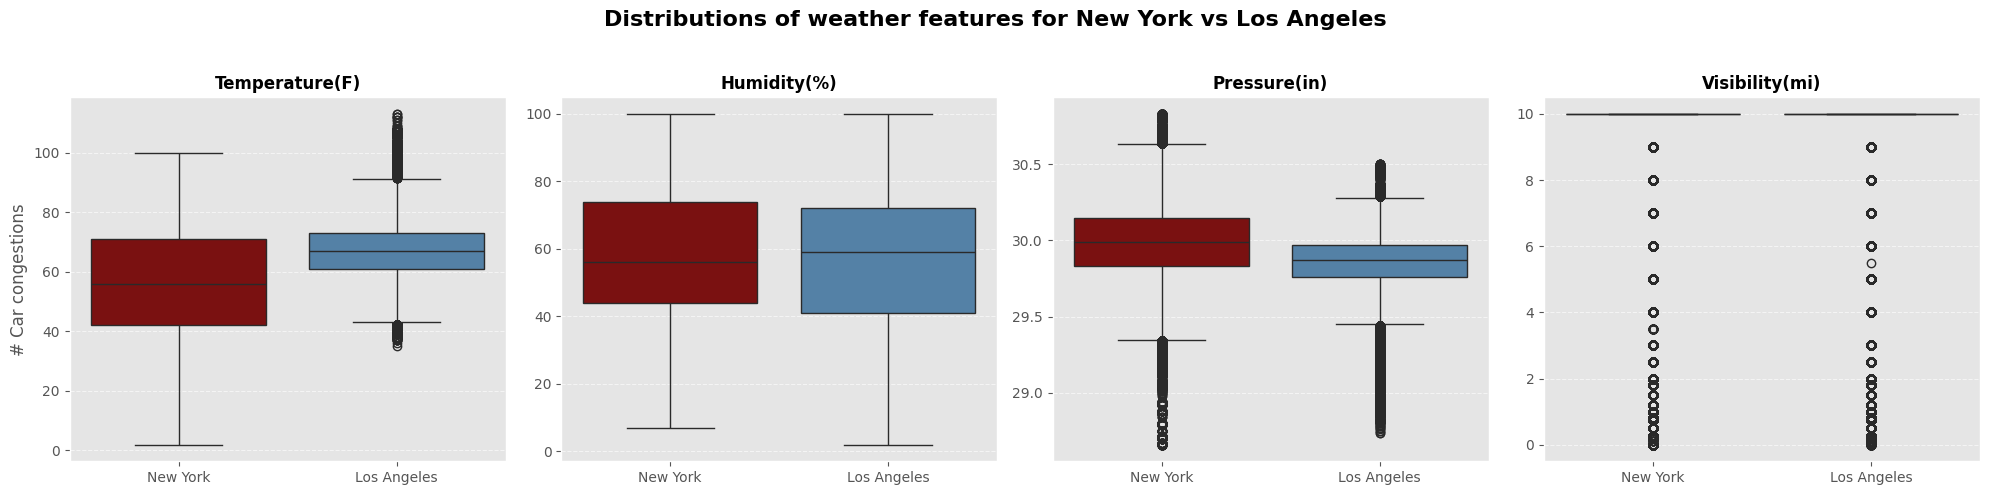

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of weather features
weather_features = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)'
]

# Custom colors
colors = ['darkred', 'steelblue']
palette = {'New York': colors[0], 'Los Angeles': colors[1]}

# Filter data
cities = ['New York', 'Los Angeles']
incident_counts = data.groupby(['StartTime']).size().reset_index(name='number of car congestions')
merged = pd.merge(data, incident_counts, on='StartTime')
filtered = merged[merged['City'].isin(cities)]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(weather_features), figsize=(20, 5), sharey=False)
fig.suptitle("Distributions of weather features for New York vs Los Angeles", fontsize=16, fontweight='bold')

# Plot each weather feature
for i, feature in enumerate(weather_features):
    ax = axes[i]
    sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax)
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.set_xlabel("")  # Remove x-axis label
    ax.set_ylabel("# Car congestions" if i == 0 else "")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() 


## Results of weather attributes

In terms of **temperature**, the average value in **Los Angeles** is slightly higher than in **New York**, and its distribution is narrower. LA also had significantly more outliers than NY. This suggests that LA generally experiences warmer temperatures, and the narrow spread could indicate that **traffic congestion in LA tends to occur within a smaller, more predictable temperature range**.

For **humidity**, the distributions were very similar between the two cities, with no obvious differences. This might suggest that both cities respond similarly to humidity levels.

Regarding **pressure**, values were slightly lower in both LA and NY, although we disregard analyzing or drawing conclusions regarding this feature due to a lack of a meaningful relationship with traffic in the city. 

As for **visibility**, the data showed many outliers, but most values were concentrated around **10 miles**, suggesting that clear visibility is common in both cities. However, this variable may be challenging to directly relate to the causes of traffic congestion, as low visibility is not frequently observed (only 3% observations below 3 miles).

## Other features - boxplots


Furthermore, we compared additional attributes related to traffic congestion, including **`Severity`**, **`Distance`**, **`DelayFromTypicalTraffic`**, **`DelayFromFreeFlowSpeed`**, and **`Congestion_Speed`**.

/tmp/ipykernel_43/1899271494.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax,showfliers=False)
/tmp/ipykernel_43/1899271494.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax,showfliers=False)
/tmp/ipykernel_43/1899271494.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax,showfliers=False)
/tmp/ipykernel_43/1899271494.py:27: FutureWarning: 

Passing `palette`

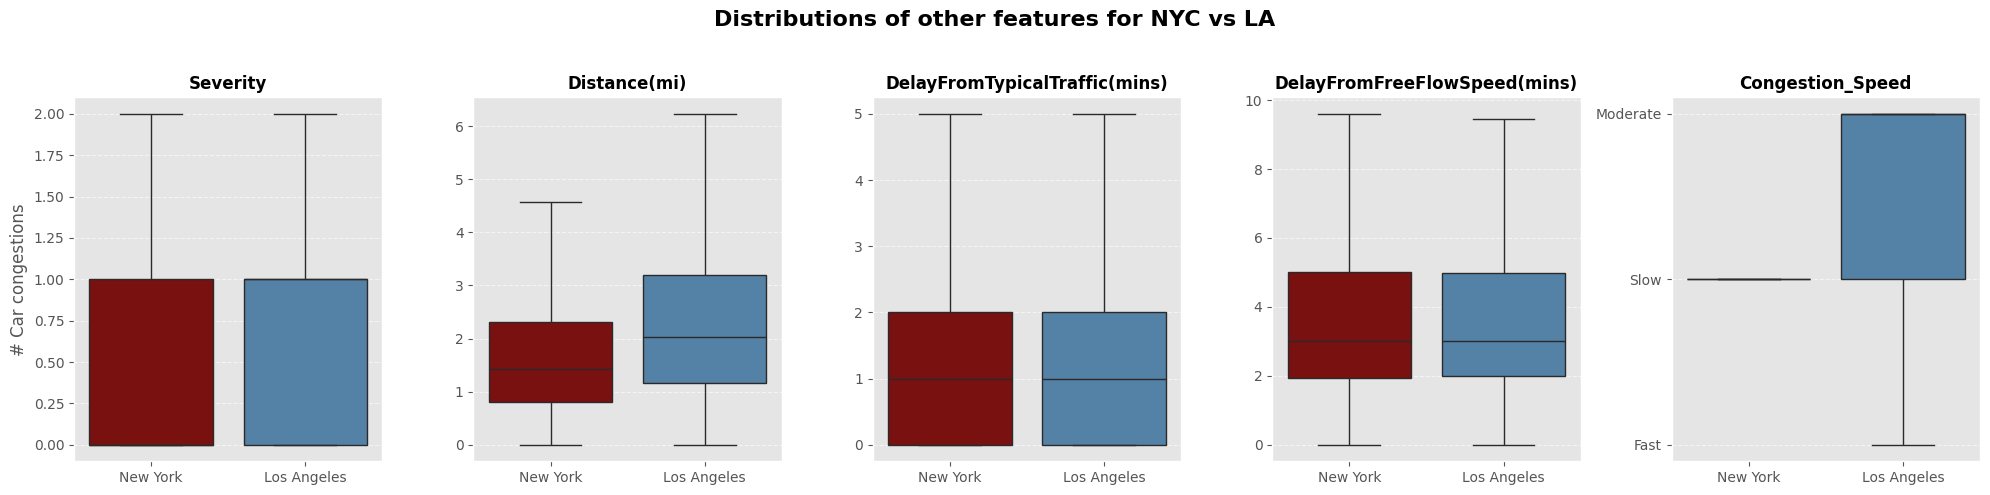

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of weather features
weather_features = [
    'Severity', 'Distance(mi)',
       'DelayFromTypicalTraffic(mins)', 'DelayFromFreeFlowSpeed(mins)',
       'Congestion_Speed']

colors = ['darkred', 'steelblue']
palette = {'New York': colors[0], 'Los Angeles': colors[1]}

# Filter data
cities = ['New York', 'Los Angeles']
incident_counts = data.groupby(['StartTime']).size().reset_index(name='number of car congestions')
merged = pd.merge(data, incident_counts, on='StartTime')
filtered = merged[merged['City'].isin(cities)]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(weather_features), figsize=(20, 5), sharey=False)
fig.suptitle("Distributions of other features for NYC vs LA", fontsize=16,fontweight="bold")

# Plot each weather feature as a separate boxplot without fliers 
for i, feature in enumerate(weather_features):
    ax = axes[i]
    sns.boxplot(x='City', y=feature, data=filtered, palette=palette, ax=ax,showfliers=False)
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("") if i != 0 else ax.set_ylabel("# Car congestions")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Results boxplot of other features
The distributions for **`Severity`**, **`DelayFromTypicalTraffic`**, and **`DelayFromFreeFlowSpeed`** appeared very similar in both cities, suggesting that traffic conditions tend to deviate from normal flow in comparable ways in New York and Los Angeles.

However, the **`Distance`** attribute showed higher values in **Los Angeles** compared to **New York**, which may reflect the city's more broad network with many highways and longer average trip lengths.

As for **`Congestion_Speed`**, the distribution in LA was more evenly spread across **slow to moderate speeds**, while in NY, it was skewed heavily toward **slower speeds only**. This indicates that congestion in New York tends to be more severe in terms of reduced travel speed, whereas in LA, there's a broader range of congestion severity.


## Influence of Weather conditions (categorical) on the typical traffic delay

We further investigated the attribute **Weather Conditions**, which consists of 59 different observed weather types such as *storm*, *thunder*, *snow*, and *rain*. Our objective was to determine whether deviations from typical traffic delays were influenced by specific weather conditions.

To explore this, we created **boxplots** showing the distribution of traffic delays for each weather category. We aimed to identify any conditions that were associated with notably higher delays.

However, the initial results did not reveal any strong or consistent patterns. One major limitation was that many weather categories had **very few observations**, which hindered the reliability of the findings. To mitigate this, we grouped similar conditions by making a mapping (e.g., merging **"Cloudy"** and **"Cloudy/Windy"**) to form broader categories with more data points, hoping to uncover clearer trends. 

Despite this adjustment, the results remained largely unchanged—**no specific weather condition consistently led to increased delays** compared to others.

/root/venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/root/venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


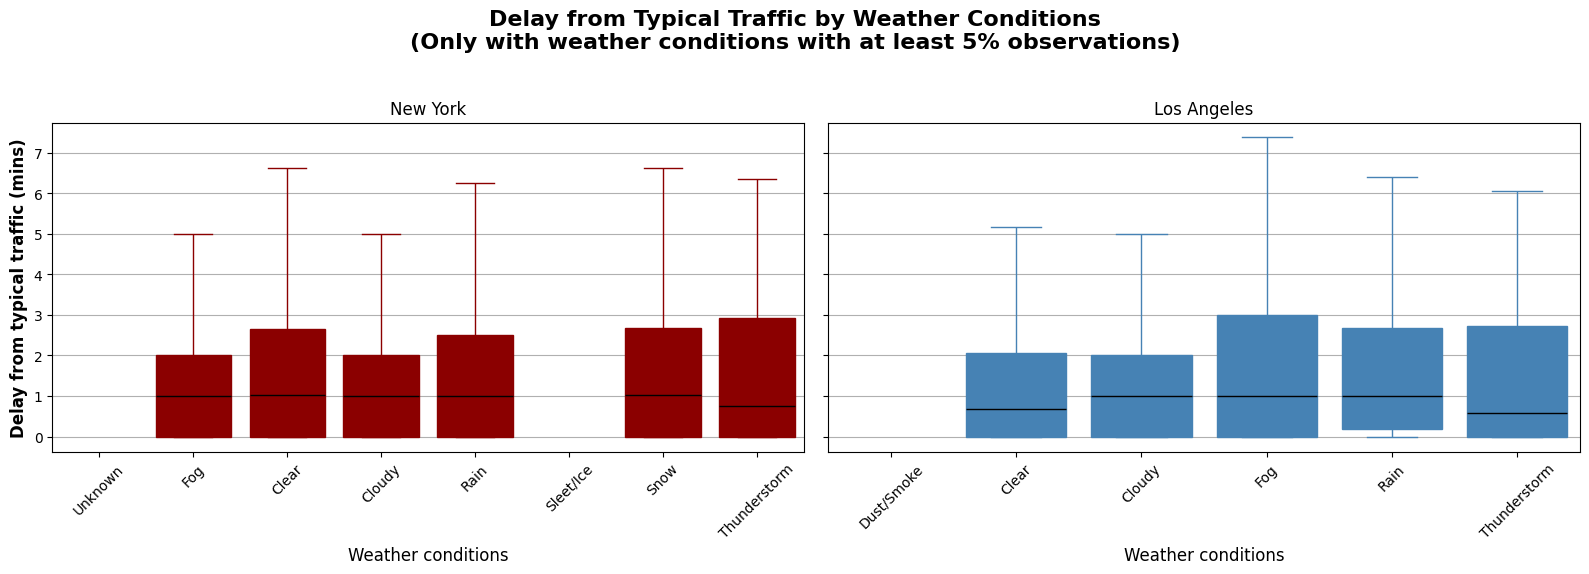

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cities and corresponding colors
cities = ['New York', 'Los Angeles']
colors = ['darkred', 'steelblue']

# Filter weather conditions with > 100,000 observations
weather_counts = data['Weather Condition Map'].value_counts()
valid_conditions = weather_counts[weather_counts > 1].index
filtered_data = data[data['Weather Condition Map'].isin(valid_conditions)]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cities), figsize=(16, 6), sharey=True)

for i, city in enumerate(cities):
    ax = axes[i]
    city_data = filtered_data[filtered_data["City"] == city]

    # Sort weather conditions by median delay
    order = (
        city_data.groupby('Weather Condition Map')['DelayFromTypicalTraffic(mins)']
        .median()
        .sort_values()
        .index
    )

    sns.boxplot(
        data=city_data,
        x='Weather_Conditions',
        y='DelayFromTypicalTraffic(mins)',
        order=order,
        showfliers=False,
        ax=ax,
        boxprops=dict(color=colors[i]),
        medianprops=dict(color='black'),
        whiskerprops=dict(color=colors[i]),
        capprops=dict(color=colors[i]),
        flierprops=dict(markeredgecolor=colors[i])
    )

    ax.set_title(f"{city}", fontsize=12)
    ax.set_xlabel('Weather conditions', fontsize=12)
    ax.set_ylabel('Delay from typical traffic (mins)' if i == 0 else '', fontsize=12, fontweight="bold")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y')

# Main title
plt.suptitle('Delay from Typical Traffic by Weather Conditions\n(Only with weather conditions with at least 5% observations)',
             fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Results weather conditions (categorical)
Upon examining the distributions, we observed that they are all quite similar in terms of **width and mean**, suggesting a lack of significant variation across different weather conditions.

Interestingly, the **tails** of the distributions for *Thunderstorm* in NYC appear slightly more extended than those for the conditions. However, since the **means** of the distributions are approximately the same, there is no compelling evidence to suggest that any particular weather condition has a notable impact on traffic delays. Overall, the data did not reveal any meaningful trends or deviations worthy of further investigation in this area. Thus, in the next section, we now seeked to instead analyzing the numerical weather attributes in order to see if there are any relevant observations.


### Influence of weather attributes (numerical) on the typical traffic delay - LOWESS Smoothing

We were also interested in analyzing and testing our assumption on whether the weather attributes played a role on the typical traffic delay. As we did not continue using the categorical variables ``Weather Conditions``, but still desired to analyze the Weather attributes, we instead used the 4 numeric variables ``Temperature(F)``, ``Humidity(%)``, ``Visibility(mi)``, ``Pressure(in)`` and plotted these on the $x$-axis with ``DelayFromTypicalTraffic(mins)`` on the $y$-axis. However, due to having ``2139`` unique values for typical traffic delay, and only between ``25-215`` unique values for the weather attributes and approximately $1.5$ million observations, we decided to bin the weather attributes in dynamic equal sized bins, such that each attribute has less bins than amount of unique values. To further migitate possible fluctuations for few observations, we used LOWESS smoothing in an attempt to capture a global trend for each weather attribute in relation to delay in typical traffic. 

/tmp/ipykernel_43/1773861725.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = data_city.groupby('binned')[att].mean()
/tmp/ipykernel_43/1773861725.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay = data_city.groupby('binned')['DelayFromTypicalTraffic(mins)'].mean()
/tmp/ipykernel_43/1773861725.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = data_city.groupby('binned')[at

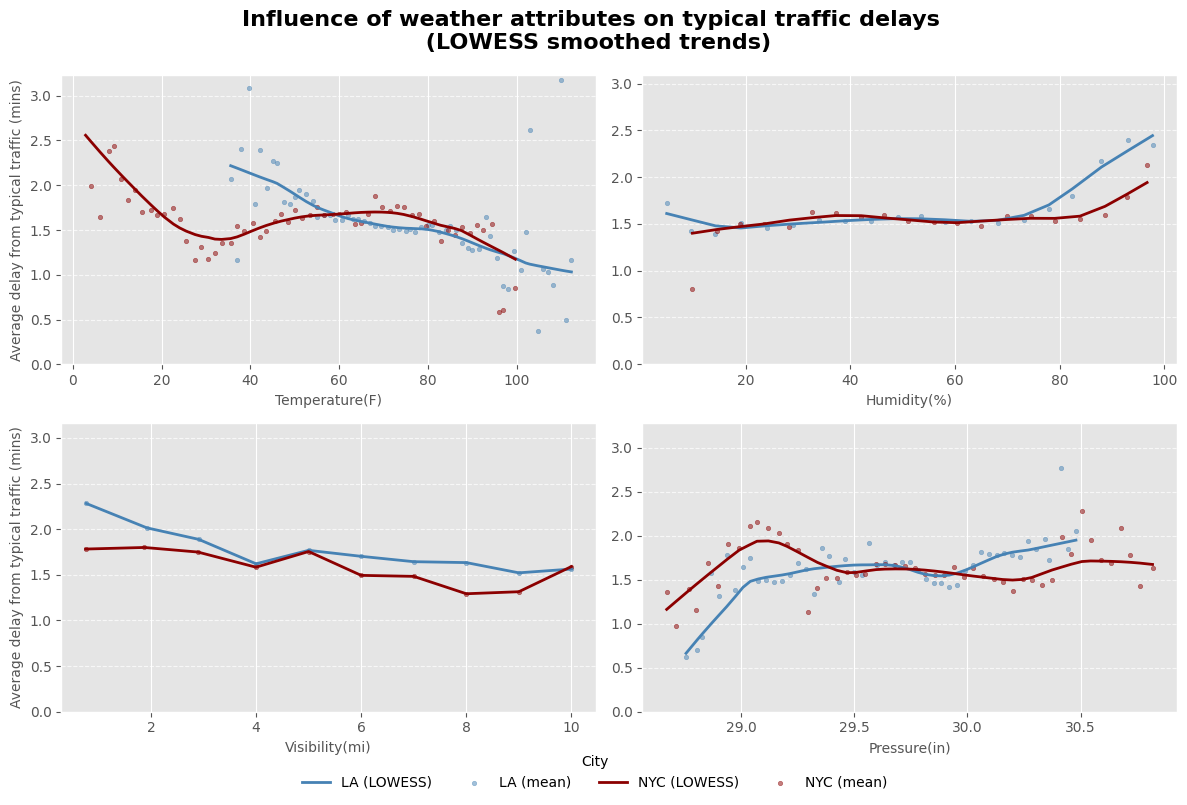

In [50]:
# Define weather attributes to plot
weather_attributes = ['Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Pressure(in)']
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'

# Setup subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Use consistent custom colors
colors = {'LA': 'steelblue', 'NYC': 'darkred'}

for i, att in enumerate(weather_attributes):
    ax = axes[i]

    for city_name, df_city in zip(['LA', 'NYC'], [df_LA, df_NYC]):
        # Drop missing values
        data_city = df_city[[att, 'DelayFromTypicalTraffic(mins)']].dropna()

        # Bin the weather attribute into equal bin widths depending on how many unique value each attribute has
        # Dynamic bin count based on attribute
        if att == 'Temperature(F)':
            n_bins = min(60, data_city[att].nunique())
        elif att == 'Humidity(%)':
            n_bins = min(20, data_city[att].nunique())
        elif att == 'Visibility(mi)':
            n_bins = min(10, data_city[att].nunique())
        elif att == 'Pressure(in)':
            n_bins = min(50, data_city[att].nunique())
        else:
            n_bins = 30  # default fallback

        data_city['binned'] = pd.cut(data_city[att], bins=n_bins)

        # Compute mean bin center and average delay
        bin_centers = data_city.groupby('binned')[att].mean()
        avg_delay = data_city.groupby('binned')['DelayFromTypicalTraffic(mins)'].mean()

        x = bin_centers.values
        y = avg_delay.values

        # LOWESS smoothing
        # Plot only once for legend
        show_label = (i == 0)

        lowess_smoothed = lowess(y, x, frac=0.3)  # Adjust frac for more/less smoothing
        ax.plot(
            lowess_smoothed[:, 0], lowess_smoothed[:, 1],
            linestyle='-', linewidth=2,
            label=f"{city_name} (LOWESS)" if show_label else None,
            color=colors[city_name]
        )

        ax.scatter(
            x, y,
            label=f"{city_name} (mean)" if show_label else None,
            color=colors[city_name], alpha=0.5, s=10
        )
        ax.set_ylim([0, np.nanmean(y)*2])

    # Only set y-label on left column
    if i % 2 == 0:
        ax.set_ylabel("Average delay from typical traffic (mins)", fontsize=10)

    ax.set_xlabel(att, fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Final formatting
plt.suptitle("Influence of weather attributes on typical traffic delays \n (LOWESS smoothed trends)",
             fontsize=16, fontweight="bold", y = 0.95)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol = 4, fontsize=10, title="City", frameon = False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Results LOWESS plot

First, it should be noted that approximately **20% of observations have delays greater than 3 minutes**, yet this is not fully reflected in the graphs above. This is because we compute the **mean delay** within each bin of the weather attributes, and the remaining **80% of lower-delay values** tend to dominate the mean, pulling it downward. While this dampens the impact of higher delay values, we argue that it still provides a meaningful representation of the **general relationship between weather conditions and traffic delay**. 

Looking specifically at **`Temperature(F)`**, we see that NYC generally experiences lower temperatures than LA. For both cities, **traffic delays are highest at the lowest observed temperatures**, which could reflect a tendency for people to drive more on cold days — possibly due to the inconvenience with walking, biking, or using public transport. It may also reflect the impact of more severe weather conditions such as snow or ice, which occur during colder temperatures and can increase congestion.

Interestingly, while LA shows a **steady decrease** in traffic delay as temperature rises, NYC exhibits a **nonlinear pattern**: delay initially drops but then increases around 40°F, before falling again after approximately 70°F. This could suggest that moderate cold (around 40°F) brings specific challenges — perhaps rain, windy conditions, or cautious driving — that spike delays temporarily. In contrast, the sharp decline in delay around 80°F in both cities may be due to **seasonal behaviors**, such as summer vacations or a greater shift toward alternative transportation methods in warmer weather.

We further observe for **`Humidity(%)`** that traffic delay remains relatively stable around 1.5 minutes for most humidity levels. However, starting around **80% humidity**, both cities experience an increase in delay. This may be attributed to **rain**, or simply the discomfort of high humidity making people more likely to choose car transport over walking or biking.

In the case of **`Visibility(mi)`**, the patterns are intuitive in low-visibility conditions — as visibility decreases, drivers may become more cautious, which could contribute to increased traffic delays. This relationship is evident in both cities but appears to **stabilize more clearly in LA**, suggesting that the city may be better adapted to low-visibility conditions.

# Geospatial Trend Analysis 

After conducting a general investigation into overall traffic trends in both **NYC** and **LA**, we decided to take a closer look at the **top 10 streets** in each city. Our aim was to analyze how these streets differ across various categories.

By focusing on the most frequently affected or busiest streets, we hoped to uncover more meaningful insights by minimizing the influence of less relevant or low-traffic streets. This targeted approach allows for a clearer comparison between the two cities and may reveal patterns that are otherwise obscured in broader, city-wide analyses.


## Top 10 most congested streets - bar plot
First we look into the top 10 most congested streets of both cities:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Tahoma'

# Filter data
NY_data = data[data["City"] == "New York"]
LA_data = data[data["City"] == "Los Angeles"]

# Get top 10 streets by count
ny_top = NY_data["Street"].value_counts().head(10)
la_top = LA_data["Street"].value_counts().head(10)

# Prepare data
ranks = [f'Top {i+1}' for i in range(10)]
ny_counts = ny_top.values
la_counts = la_top.values
ny_labels = ny_top.index
la_labels = la_top.index

# Bar width and positions
bar_width = 0.4
y = np.arange(len(ranks))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(y - bar_width/2, ny_counts, height=bar_width, label='New York', color='darkred')
plt.barh(y + bar_width/2, la_counts, height=bar_width, label='Los Angeles', color='steelblue')

# Annotate street names
for i in range(10):
    plt.text(ny_counts[i] + 1, y[i] - bar_width/2, ny_labels[i], va='center', fontsize=12)
    plt.text(la_counts[i] + 1, y[i] + bar_width/2, la_labels[i], va='center', fontsize=12)

plt.yticks(y, ranks)
plt.xlabel("Number of car congestions")
plt.title("Top 10 streets with most car congestions",fontsize=16,fontweight="bold")
plt.xlim(0,60000)
plt.legend()
plt.grid(axis='x')
plt.gca().invert_yaxis()  # <-- this inverts the y-axis
plt.tight_layout()
plt.show()


## Result 10 most congested streets - bar plot

The plot reveals that, among the **top 3 most congested streets**, **NYC exhibits higher levels of congestion** compared to LA. This is a notable observation that was not apparent when analyzing the full dataset all at once. By narrowing the focus to only the busiest streets, distinct patterns emerge that might otherwise be obscured by the presence of many less-trafficked streets.

One possible explanation for this difference is **urban infrastructure**: NYC tends to have **narrower streets** and a **denser street grid**, which can lead to greater bottlenecks on major roads. In contrast, LA’s urban design typically includes **wider roads** and **more dispersed traffic flow**, which may help mitigate congestion even on heavily used streets.

This insight highlights the value of **granular, location-specific analysis** and demonstrates that while LA may appear more congested overall, **individual hotspots in NYC can experience more severe congestion**.

In fact, this is a classic example of **Simpson’s paradox** — where a trend that appears in aggregated data disappears or reverses when the data is disaggregated. Although LA shows higher congestion on average, a closer look at the top streets reveals the opposite trend, emphasizing the importance of context and segmentation in data analysis. 


## Top 10 streets distance vs. delay by severity level - bokeh plot
Next up we look into the top 10 streets by distance vs delay of typical traffic in each city. This is done as a bokeh plots, where you can choose the severity level. 

In [ ]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_file, save
from bokeh.models import ColumnDataSource, Select, CustomJS, LabelSet, Legend, LegendItem
from bokeh.transform import dodge
from bokeh.layouts import column, row
import os

# --- Prepare Data ---
data['Severity'] = pd.to_numeric(data['Severity'], errors='coerce')
data['Street'] = data['Street'].fillna('Unknown')
data['DelayFromTypicalTraffic(mins)'] = pd.to_numeric(data['DelayFromTypicalTraffic(mins)'], errors='coerce').fillna(0)
data['Distance(mi)'] = pd.to_numeric(data['Distance(mi)'], errors='coerce').fillna(0)

severity_levels = sorted(data['Severity'].dropna().unique().astype(int))
colors = {'New York': 'darkred', 'Los Angeles': 'steelblue'}

# --- Build severity -> data dictionaries ---
delay_data = {}
distance_data = {}

LABEL_OFFSET = 0.2

def get_top10(df, metric):
    avg_obs_threshold = df.groupby('Street').size().mean()*0.7
    ny = (
        df[df['City'] == 'New York']
        .groupby('Street')
        .filter(lambda x: len(x) >= avg_obs_threshold)
        .groupby('Street')[metric]
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .reset_index()
    )
    la = (
        df[df['City'] == 'Los Angeles']
        .groupby('Street')
        .filter(lambda x: len(x) >= avg_obs_threshold)
        .groupby('Street')[metric]
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .reset_index()
    )
    ny.columns = ['Street', 'Value']
    la.columns = ['Street', 'Value']
    max_len = max(len(ny), len(la))
    ny = ny.reindex(range(max_len), fill_value=0).fillna({'Street': ''})
    la = la.reindex(range(max_len), fill_value=0).fillna({'Street': ''})
    ranks = [f"Top {i+1}" for i in range(max_len)]
    return {
        'rank': ranks,
        'ny_value': ny['Value'].tolist(),
        'la_value': la['Value'].tolist(),
        'ny_label': ny['Street'].tolist(),
        'la_label': la['Street'].tolist(),
        'ny_label_x': [v + LABEL_OFFSET for v in ny['Value'].tolist()],
        'la_label_x': [v + LABEL_OFFSET for v in la['Value'].tolist()]
    }

for sev in severity_levels:
    subset = data[data['Severity'] == sev]
    delay_data[str(sev)] = get_top10(subset, 'DelayFromTypicalTraffic(mins)')
    distance_data[str(sev)] = get_top10(subset, 'Distance(mi)')

delay_data["All"] = get_top10(data, 'DelayFromTypicalTraffic(mins)')
distance_data["All"] = get_top10(data, 'Distance(mi)')

initial_sev = "All"
delay_source = ColumnDataSource(data=delay_data[initial_sev])
distance_source = ColumnDataSource(data=distance_data[initial_sev])

global_max_delay = max(
    max(v['ny_value'] + v['la_value']) if v['ny_value'] else 0
    for v in delay_data.values()
)
global_max_distance = max(
    max(v['ny_value'] + v['la_value']) if v['ny_value'] else 0
    for v in distance_data.values()
)

xmax_delay = global_max_delay * 1.5
xmax_distance = global_max_distance * 1.21

# --- Create Delay Plot ---
p_delay = figure(
    y_range=list(reversed(delay_source.data['rank'])),
    x_range=(0, xmax_delay),
    height=500, width=450,
    title=f"Top 10 streets by delay of typical traffic (min) - severity level {initial_sev}",
    x_axis_label="Total Delay (mins)",
    toolbar_location=None
)
delay_ny = p_delay.hbar(y=dodge('rank', -0.18, range=p_delay.y_range), right='ny_value', height=0.3, source=delay_source, color=colors['New York'])
delay_la = p_delay.hbar(y=dodge('rank', +0.18, range=p_delay.y_range), right='la_value', height=0.3, source=delay_source, color=colors['Los Angeles'])
p_delay.add_layout(LabelSet(x='ny_label_x', y=dodge('rank', -0.31, range=p_delay.y_range), text='ny_label', source=delay_source, text_align='left', text_font_size="9pt"))
p_delay.add_layout(LabelSet(x='la_label_x', y=dodge('rank', +0.10, range=p_delay.y_range), text='la_label', source=delay_source, text_align='left', text_font_size="9pt"))

# --- Create Distance Plot ---
p_distance = figure(
    y_range=list(reversed(distance_source.data['rank'])),
    x_range=(0, xmax_distance),
    height=500, width=450,
    title=f"Top 10 streets by distance (mi) - severity level {initial_sev}",
    x_axis_label="Total Distance (mi)",
    toolbar_location=None
)
distance_ny = p_distance.hbar(y=dodge('rank', -0.18, range=p_distance.y_range), right='ny_value', height=0.3, source=distance_source, color=colors['New York'])
distance_la = p_distance.hbar(y=dodge('rank', +0.18, range=p_distance.y_range), right='la_value', height=0.3, source=distance_source, color=colors['Los Angeles'])
p_distance.add_layout(LabelSet(x='ny_label_x', y=dodge('rank', -0.31, range=p_distance.y_range), text='ny_label', source=distance_source, text_align='left', text_font_size="9pt"))
p_distance.add_layout(LabelSet(x='la_label_x', y=dodge('rank', +0.10, range=p_distance.y_range), text='la_label', source=distance_source, text_align='left', text_font_size="9pt"))

# --- Styling ---
for p in [p_delay, p_distance]:
    p.min_border_right = 50
    p.ygrid.grid_line_color = None
    p.legend.visible = False
    p.title.text_font_size = "14pt"
    p.title.text_font_style = "bold"

from bokeh.plotting import figure as create_figure
from bokeh.models import ColumnDataSource, Legend, LegendItem, CDSView, IndexFilter
from bokeh.core.properties import value

# Dummy figure for legend
legend_fig = create_figure(width=900, height=50, toolbar_location=None)
legend_fig.outline_line_color = None
legend_fig.grid.visible = False
legend_fig.axis.visible = False
legend_fig.background_fill_color = None
legend_fig.border_fill_color = None

# Use offscreen dummy data
legend_source = ColumnDataSource(data=dict(x=[100, 200], y=[100, 200]))

# Create one rect per legend item using a filtered view
ny_view = CDSView(source=legend_source, filters=[IndexFilter([0])])
la_view = CDSView(source=legend_source, filters=[IndexFilter([1])])

ny_glyph = legend_fig.rect(x='x', y='y', width=0.2, height=0.2,
                           fill_color=value(colors['New York']), line_color=None,
                           source=legend_source, view=ny_view)

la_glyph = legend_fig.rect(x='x', y='y', width=0.2, height=0.2,
                           fill_color=value(colors['Los Angeles']), line_color=None,
                           source=legend_source, view=la_view)

# Create a clean legend
legend = Legend(items=[
    LegendItem(label="New York", renderers=[ny_glyph]),
    LegendItem(label="Los Angeles", renderers=[la_glyph])
], orientation="horizontal", location="center")

legend.label_text_font_size = "12pt"
legend.label_text_font_style = "bold"
legend.glyph_height = 20
legend.glyph_width = 20

legend_fig.add_layout(legend, 'center')


# --- Dropdown ---
select = Select(
    title="Select Severity Level",
    value=initial_sev,
    options=["All"] + [str(s) for s in severity_levels]
)

select.js_on_change('value', CustomJS(args=dict(
    delay_source=delay_source,
    distance_source=distance_source,
    delay_data=delay_data,
    distance_data=distance_data,
    p_delay=p_delay,
    p_distance=p_distance
), code="""
    const sev = cb_obj.value;
    const new_delay = delay_data[sev];
    const new_distance = distance_data[sev];

    delay_source.data = new_delay;
    distance_source.data = new_distance;

    p_delay.y_range.factors = [...new_delay.rank].reverse();
    p_distance.y_range.factors = [...new_distance.rank].reverse();

    p_delay.title.text = `Top 10 Streets by Delay - Severity ${sev}`; 
    p_distance.title.text = `Top 10 Streets by Distance - Severity ${sev}`; 

    delay_source.change.emit();
    distance_source.change.emit();
"""))

# --- Show instead of Save ---
show(column(select, legend_fig, row(p_delay, p_distance)))


## Results distance vs delay by severity - bokeh plot

The results from these plots, considering **all severity levels**, align well with expectations: the **distances of car congestion** are generally **longer in Los Angeles** compared to **New York City**. This makes intuitive sense, as **LA spans a much larger geographical area** than NYC.

However, when focusing on **severity levels 0, 1, and 2**, an interesting pattern emerges: the **longest congestion distances occur in NYC**, not LA. This suggests that **lower severity levels may have a smaller effect on congestion distance in LA** compared to NYC. In other words, **longer distances do not necessarily translate into more severe congestion in NYC**, whereas in LA, **distance may contribute more directly to higher congestion severity**. 

In contrast, at **severity level 3 (the most severe)**, the **congestion distances are significantly longer in LA** than in NYC, reinforcing the influence of geographic scale at higher severity levels.

When examining the **delay compared to typical traffic**, **NYC consistently shows longer delays overall**. However, **LA shows longer delays at severity levels 0 and 1**. This is notable because, despite LA having **shorter congestion distances** at these levels, the **delays are still higher**. This may indicate that a **high number of vehicles are concentrated in smaller areas**, causing longer-lasting congestion even when distances are not extreme. 

At **severity level 3**, **LA exhibits longer distances but shorter delays**, while **NYC shows shorter distances but longer delays**. This contrast suggests that in NYC, **severe congestion might involve more densely packed vehicles in compact areas**, leading to extended delays even over shorter distances. In contrast, **severe congestion in LA may involve more spread-out traffic over longer distances**, resulting in less delay despite greater distance. 


## Hotspots of car congestions by hour of the day - Matrix heatmap


Further, we explored **congestion hotspots** in both cities by creating a **heatmap matrix** showing the 10 most congested streets in each city across the hours of the day. This allowed us to examine which locations experience the most traffic and when during the day.

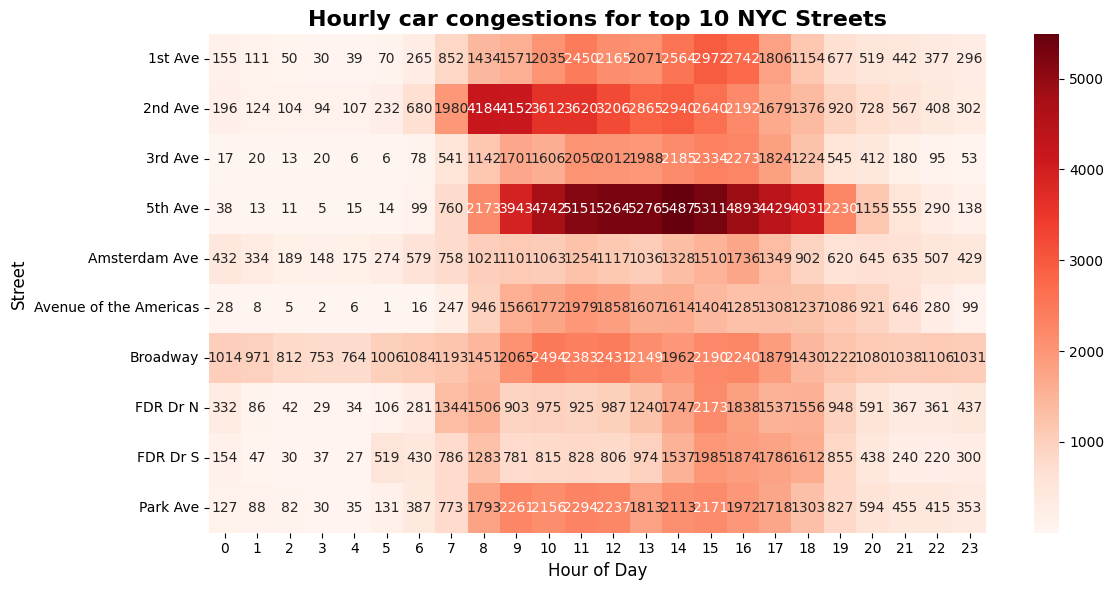

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'StartHour' column exists
data['StartHour'] = data['StartTime'].dt.hour

df_NYC = data[data["City"] == "New York"]
df_LA = data[data["City"] == "Los Angeles"]

# Get top 10 LA streets
top10streets_NYC = df_NYC['Street'].value_counts().head(10)

# Top 10 streets in NYC
top10streets_NYC_names = top10streets_NYC.index

# Filter to top streets
df_top_NYC = df_NYC[df_NYC['Street'].isin(top10streets_NYC_names)]

# Group and pivot for heatmap
heatmap_data = df_top_NYC.groupby(['Street', 'StartHour']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Hourly car congestions for top 10 NYC Streets',fontsize=16,fontweight="bold")
plt.xlabel('Hour of Day',fontsize=12)
plt.ylabel('Street',fontsize=12)
plt.tight_layout()
plt.show()

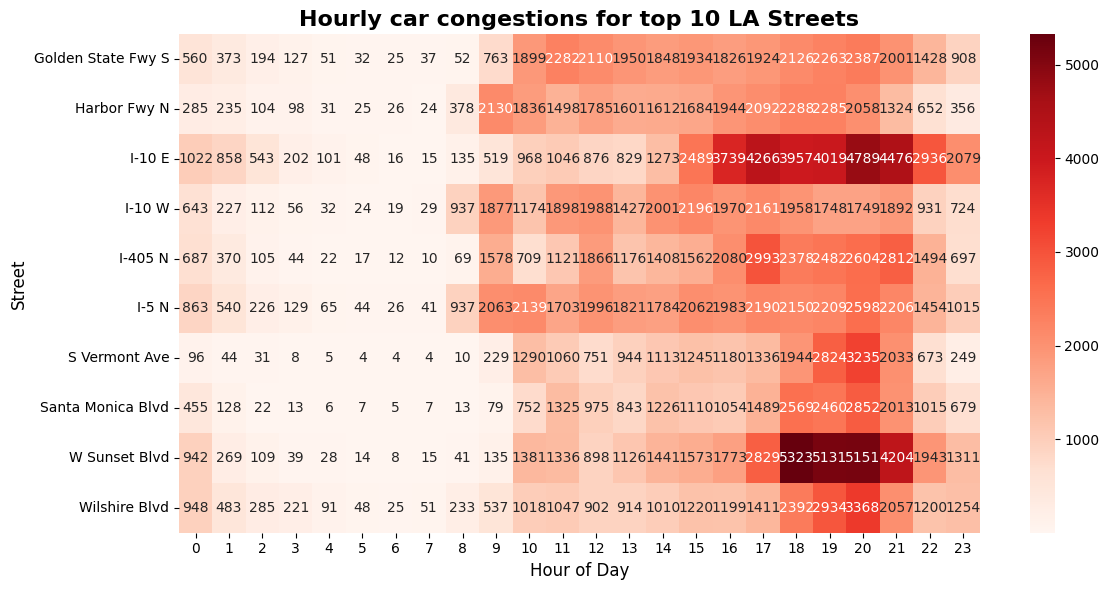

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'StartHour' column exists
data['StartHour'] = data['StartTime'].dt.hour

# Filter by city
df_LA = data[data["City"] == "Los Angeles"]

# Get top 10 LA streets
top10streets_LA = df_LA['Street'].value_counts().head(10)

# Filter to top streets
df_top_LA = df_LA[df_LA['Street'].isin(top10streets_LA.index)]

# Group and pivot for heatmap
heatmap_data = df_top_LA.groupby(['Street', 'StartHour']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Hourly car congestions for top 10 LA Streets', fontsize=16, fontweight="bold")
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Street', fontsize=12)
plt.tight_layout()
plt.show()


#### Results of Matrix heatmap

One key insight from the matrix heatmaps—beyond what was previously observed—is that although the plots show the **top 10 most congested streets by hour**, patterns vary notably by street. In **New York City**, streets like **5th Ave** and **2nd Ave** show highly concentrated congestion between **8 and 19** reflecting popular and possibly people-dependent streets. In contrast, streets like **Amsterdam Ave** and **Broadway** show a more **even distribution** of congestion throughout the day. This suggests that while some roads serve primarily as commuter routes, others experience consistent traffic across different hours.


# Geographical heatmap

To make this analysis more intuitive and visually engaging, we converted these static heatmap matrices into **dynamic heatmaps** displayed on actual maps of **New York City** and **Los Angeles**. This made it easier to observe how congestion patterns shift geographically throughout the day in each city. 


In [ ]:
import pandas as pd
import plotly.express as px

# Ensure time column is datetime
data["StartTime"] = pd.to_datetime(data["StartTime"])

# Filter to Los Angeles
data_LA = data[data["City"] == "New York"]

# Get top 10 streets by frequency
top10_streets = data_LA["Street"].value_counts().head(10).index.tolist()

# Filter to top 10 streets
top_street_data = data_LA[data_LA["Street"].isin(top10_streets)]

# Drop rows with missing coordinates or time
top_street_data = top_street_data.dropna(subset=["Start_Lat", "Start_Lng", "StartTime"])

# Extract hour of day as integer (for correct sorting), and create a label for display
top_street_data["Hour"] = top_street_data["StartTime"].dt.hour
top_street_data["HourLabel"] = top_street_data["Hour"].apply(lambda h: f"{h:02d}:00")

# Create a scatter map with animation by hour label (but sorted by integer hour)
fig = px.scatter_mapbox(
    top_street_data.sort_values("Hour"),  # Ensure chronological frame order
    lat="Start_Lat",
    lon="Start_Lng",
    color="Street",  # Optional: color by street
    animation_frame="HourLabel",
    hover_name="Street",
    zoom=11,
    center=dict(lat=top_street_data["Start_Lat"].mean(), lon=top_street_data["Start_Lng"].mean()),
    mapbox_style="carto-positron",
    title="Hourly top 10 most car congested streets in New York City"
)

# Keep zoom/pan consistent across animation frames
fig.update_layout(
    mapbox=dict(uirevision="keep-zoom"),
    margin={"r":0, "t":50, "l":0, "b":0},
    width = 700, height=600
)

# Show the figure
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Ensure time column is datetime
data["StartTime"] = pd.to_datetime(data["StartTime"])

# Filter to Los Angeles
data_LA = data[data["City"] == "Los Angeles"]

# Get top 10 streets by frequency
top10_streets = data_LA["Street"].value_counts().head(10).index.tolist()

# Filter to top 10 streets
top_street_data = data_LA[data_LA["Street"].isin(top10_streets)]

# Drop rows with missing coordinates or time
top_street_data = top_street_data.dropna(subset=["Start_Lat", "Start_Lng", "StartTime"])

# Extract hour of day as integer (for correct sorting), and create a label for display
top_street_data["Hour"] = top_street_data["StartTime"].dt.hour
top_street_data["HourLabel"] = top_street_data["Hour"].apply(lambda h: f"{h:02d}:00")

# Create a scatter map with animation by hour label (but sorted by integer hour)
fig = px.scatter_mapbox(
    top_street_data.sort_values("Hour"),  # Ensure chronological frame order
    lat="Start_Lat",
    lon="Start_Lng",
    color="Street",  # Optional: color by street
    animation_frame="HourLabel",
    hover_name="Street",
    zoom=11,
    center=dict(lat=top_street_data["Start_Lat"].mean(), lon=top_street_data["Start_Lng"].mean()),
    mapbox_style="carto-positron",
    title="Hourly top 10 most car congested streets in Los Angeles"
)

# Keep zoom/pan consistent across animation frames
fig.update_layout(
    mapbox=dict(uirevision="keep-zoom"),
    margin={"r":0, "t":50, "l":0, "b":0},
    width = 700, height=600
)

# Show the figure
fig.show()


#### Results hotspots heatmap - Geospatial
The hotspots heatmap illustreate the top 10 most congested streets throughout a day in respectively NYC and Los Angles. 

First, investigating the heatmap of NYC, it is evident that the city area and top car congested streets are very close to one another. Hence, many very car congested streets cross each other, which could indicate also why the high time delays are more evident in NYC, and may therefore not only reflect the number of cars, but simply traffic in very little area. Moreover, it is seen that the most busy hours are from 9 AM to 5 PM. Additioally, the distribution of car congestions at Broadway seem to be more even throughout the day. This makes sense as Broadway is known for many nightlifes activities such as theaters and concerts [10]. Whereas 5th aveny that is the most car congested street is very narrowly distributed in time. Thus, during the day as it is a two way street between 143rd and 135th streets, and one-way traffic southbound for the rest of its route, this can also cause very high car congestion [12].   

Next, investigating the heatmap of LA, the streets are much longer than in NYC. Addtionally, more spread out, making the car congestions longer in distance as we already saw previously.The most congested street of LA is the I-10-E, which is a transcontinental interstate highway [13]. Moreover, as in NYC, LA is very busy between 9 AM to 5 PM. However, the most busy hours of the city is actually from 4 PM to 8 PM. 

# Genre. Which genre of data story did you use?

#### **Which genre of data story did you use?**

Our project is structured as a **Magazine Style** following an **"Explanatory Analysis"** genre of data storytelling. The goal was to guide the audience through a structured narrative using data visualizations to explain when, where, and how car congestion occurs in Los Angeles and New York City. We aimed to reveal patterns and provide interpretations, rather than simply presenting raw data or letting users explore entirely on their own.


### Visual Narrative Tools (Based on Figure 7 from Segal and Heer)

#### **Visual Structuring**
- We used a **Timebar/Progress Bar** concept to visualize congestion patterns across a 24-hour day. This helped the audience clearly identify rush hours and understand how traffic ebbs and flows throughout the day in each city.

#### **Highlighting**
- We applied **Feature Distinction** by consistently color-coding New York City and Los Angeles, as well as different severity levels, across all charts. This made it easy to distinguish key variables and enhanced visual clarity.

#### **Transition Guidance**
- We used **Familiar Objects**, such as consistent color schemes and similar chart styles, across different visualizations. By keeping colors for NYC and LA constant throughout, we minimized confusion and helped the viewer follow the story without needing to re-learn visual cues in each section.


### Narrative Structure Tools (Also from Figure 7) 

#### **Ordering**
- We structured the narrative in a **Linear** fashion, starting with high-level yearly trends and gradually narrowing down to more detailed daily and hourly patterns. We also covered weather related influences and spatial distributions, ending with fine-grained insights like local congestion severity in each city and how it influence delay and distance of congestions.

#### **Interactivity**
- We incorporated **Filtering and Selection** in interactive plots using tools like Bokeh. These allow users to filter by severity level, encouraging exploration of specific aspects of the data that are most relevant or interesting to them.

#### **Messaging**
- We used **Captions and Headlines** to guide interpretation and reinforce the key message of each chart. Titles were crafted with references to traffic-related themes to keep the tone engaging and contextually relevant.


Together, these tools helped us build a cohesive, engaging, and informative data narrative that reveals complex urban congestion dynamics in an accessible way for respective NYC and LA.


### Visualizations

#### **Explain the visualizations you've chosen**

In this project, we employed a wide range of visualizations to analyze car congestion patterns in New York City and Los Angeles from 2016 to 2022. Each type of visualization was carefully selected to reveal a different aspect of the data, from temporal trends to spatial distributions and weather-based influences. Below is a breakdown of the main visual tools we used:

- **Histograms**: These were used to explore the **temporal distribution** of congestion events across different periods—such as years and weekdays. This helped us understand how frequently congestion occurred and when peaks were most likely to happen.

- **Calendar plots**: These visualizations captured **yearly and weekly congestion trends**. They were especially effective at showing how congestion varied across seasons and highlighted specific low-traffic dates.

- **Polar charts**: Polar plots were used to visualize **hourly patterns of congestion severity**. These are great for cyclical data like hours of the day, and made it easy to see when the most severe congestion events tended to occur.

- **Heatmaps (geospatial)**: These were used to show **hourly congestion intensity across different areas of each city**. The heatmaps revealed how traffic varied not just over time, but also by location, and helped compare congestion hotspots in NYC and LA.

- **Boxplots**: Boxplots were included to visualize the **distribution and spread of various features**, such as temperature, visiability. They were useful for spotting outliers and understanding variability in the data, and for comparison of distributions across cities.

- **LOWESS (Locally Weighted Scatterplot Smoothing) plots**: We used LOWESS to model and visualize **relationships between congestion delays and weather-related features**, such as humidity and temperature. This method helped us see trends that would be hidden in raw scatterplots, without imposing a strict linear relationship.

- **Histograms and Bokeh plots**: In addition to their use in general distributions, histograms and **interactive Bokeh plots** were utilized to explore **local congestion trends** in more detail. The Bokeh plots allowed users to interact with the data—zooming in, hovering to see details, and comparing congestion trends across neighborhoods or cities.

#### **Why are they right for the story you want to tell?**

These visualizations were chosen to support a multifaceted exploration of congestion, aimed at answering several key questions: *When* does congestion occur? *Where* is it most intense? *How bad* is it? And *what factors* might influence it?

- **Temporal plots (histograms, calendar plots, polar charts)** were essential to uncovering **time-based patterns**, such as weekday rush hours and seasonal trends. For example, congestion was clearly higher on weekdays and dipped during holidays.

- **Heatmaps and geospatial plots** gave us insight into **spatial dynamics**, showing how congestion is distributed across each city and how that distribution changes by hour.

- **Severity plots and boxplots** allowed us to examine not just frequency, but **intensity and variability**, helping us differentiate between minor and major congestion events.

- **LOWESS plots** were key in exploring **weather related influences**, such as how weather conditions may correlate with delays, without forcing the data into a fixed model.

- **Interactive Bokeh plots** added a **user-driven exploratory layer**, enabling us (and viewers) to dig deeper into local trends in an intuitive and flexible way.


## Discussion. Think critically about your creation
#### What went well?

We successfully explored congestion patterns across different time scales—daily, weekly, and yearly—and were able to clearly compare how congestion behaves over time in both Los Angeles and New York City. This gave us a solid understanding of temporal trends at a broad level.

To deepen our analysis, we focused on the **top 10 most congested streets** in each city. This allowed us to conduct a more granular investigation. Through this, we discovered a notable difference: in **Los Angeles**, the most severe congestion events tended to occur over **longer distances**, whereas in **New York City**, the most severe congestion was often limited to **shorter distances**.

This difference is likely due to the **urban structure and transportation behavior** in each city. LA is a more car-dependent city with wider roadways and longer commute distances. In contrast, NYC is denser, with shorter road networks — especially in central areas — leading to more intense congestion even over short distances.


#### What is still missing? What could be improved, and why?
We also could have examined how **severity, distance, and delay vary between weekdays and weekends**. There may be meaningful differences in traffic behavior depending on the day of the week, and comparing these patterns could uncover why certain delays happen more frequently at specific times. 

Similarly, a deeper look into **specific time slots with high congestion** such as rush hours could reveal how congestion severity or delay changes throughout the day. Exploring these patterns in more detail might help explain not just *when* congestion happens, but *why*. 

These additional layers of analysis could provide more insight into congestion behavior and help uncover relationships that remain hidden in broader temporal or spatial trends.

Moreover, we also believe that it would be a good idea to support the analysis with another dataset supporting more how the weather conditions influence traffic. We did not get very much in depth on this part unfortunately as we believed that our dataset was a bit limited in this area.



## Contributions. Who did what?
#### You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain). It is not OK simply to write "All group members contributed equally".

The data set investigation was conducted my Mona, Mariana, Christian. Ultimately, Mona finding the 'perfect' data set. The data preprocessing was done by Mariana and Mona including decisions on what attributes to drop etc with input from Christian. Basic stats and thorough background investigation was conducted by Mona. Histograms, calender plots, and bokeh plots was done by Mariana. Polar charts, LOWESS plots and histogram was done by Mona. Christian conducted the heatmaps along with elaborations on the heatmaps. Mariana and Mona were in charge of the explainer notebook, and Christian was in charge of the website. However, we will emphasize that we did very much of the analysis as a group and we discussed how to tell the story and how to make the best visualizations as a group with everyones agreement and suggestions continously throughout the whole working process. 


## References
[1] Moosavi, S., Samavatian, M. H., Nandi, A., Parthasarathy, S., & Ramnath, R. (2019). Short and long-term pattern discovery over large-scale geo-spatiotemporal data. Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 2905–2913. https://doi.org/10.1145/3292500.3330755

[2] Insider Monkey. (n.d.). *30 most densely populated cities in the US*. Yahoo Finance. Retrieved May 13, 2025, from https://finance.yahoo.com/news/30-most-densely-populated-cities-140312195.html

[3] Car and Driver. (2021, August 30). What will New York do with the cars they purchased during the pandemic? Retrieved May 13, 2025, from https://www.caranddriver.com/features/a37293032/what-will-new-york-do-with-the-cars-they-purchased-during-the-pandemic/

[4] New York Times. (2020, August 12). Car buying in New York during the coronavirus pandemic. Retrieved May 13, 2025, from https://www.nytimes.com/2020/08/12/style/car-buying-new-york-coronavirus.html

[5] Wikipedia. (n.d.). New York City. Wikipedia, den frie encyklopædi. Retrieved May 13, 2025, from https://da.wikipedia.org/wiki/New_York_City

[6] Wikipedia. (n.d.). Los Angeles. Wikipedia, den frie encyklopædi. Hentet 13. maj 2025 fra https://da.wikipedia.org/wiki/Los_Angeles

[7] Drivemode. (2018, June 20). Drivemode data report: Where and when commuting takes the longest. Retrieved May 13, 2025, from https://www.drivemode.com/blog/engineering/drivemode-data-report-commuting-durations/

[8]  Statista. 2023. Annual economic losses from traffic congestion in selected urban areas in the United States in 2022 (in billion U.S. dollars). Retrieved May 13, 2025 from https://www.statista.com/chart/21085/annual-economic-losses-from-traffic-congestion/

[9] Visual Capitalist. 2021. How Many Hours Do Americans Lose to Traffic Congestion? Retrieved May 13, 2025, from https://www.visualcapitalist.com/how-many-hours-do-americans-lose-to-traffic-congestion/

[10] Broadway.com. (n.d.). Introductory guide to Broadway. Retrieved May 13, 2025, from https://www.broadway.com/broadway-guide/2/introductory-guide-to-broadway/

[11] Wikipedia. (n.d.). Fifth Avenue. Retrieved May 13, 2025, from https://en.wikipedia.org/wiki/Fifth_Avenue

[12] Wikipedia. (n.d.). Interstate 10 in California. Retrieved May 13, 2025, from https://en.wikipedia.org/wiki/Interstate_10_in_California

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e1fc5d7b-48de-4a64-a50a-817cb903e0cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>